# 스트리밍 모드

`graph`의 전체 상태를 **스트리밍**하는 방법

LangGraph는 여러 스트리밍(Streaming) 모드를 지원합니다. 

주요 모드는 다음과 같습니다

- `values`: 이 스트리밍 모드는 그래프의 값들을 스트리밍합니다. 이는 각 노드가 호출된 후의 **그래프의 전체 상태**를 의미합니다.
- `updates`: 이 스트리밍 모드는 그래프의 업데이트 내용을 스트리밍합니다. 이는 각 노드가 호출된 후의 **그래프 상태에 대한 업데이트**를 의미합니다.
- `messages`: 이 스트리밍 모드는 각 노드의 메시지를 스트리밍합니다. 이때 **LLM 의 토큰 단위의 출력 스트리밍** 도 가능합니다.

## 환경설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph


## 그래프 정의하기

이 가이드에서는 간단한 에이전트를 사용하겠습니다.

In [3]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_teddynote.tools import GoogleNews
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )


# 도구 리스트 생성
tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4.1-nano")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[search_keyword])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = graph_builder.compile()

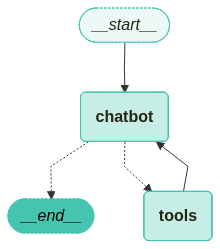

In [7]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## 노드의 단계별 출력

**스트리밍 모드**
- `values`: 각 단계의 현재 상태 값 출력
- `updates`: 각 단계의 상태 업데이트만 출력 (기본값)
- `messages`: 각 단계의 메시지 출력

여기서 스트리밍의 의미는 LLM 출력시 토큰 단위로 스트리밍하는 개념이 아니라, 단계별로 출력하는 의미를 가집니다.

### `stream_mode = "values"`

`values` 모드는 각 단계의 현재 상태 값을 출력합니다.

**참고**

`chunk.items()`

- `key`: State 의 key 값
- `value`: State 의 key 에 대한하는 value

#### 동기(Synchronous) 방식의 스트리밍

- `chunk` 는 dictionary 형태(key: State 의 key, value: State 의 value)

In [9]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="values")
for chunk in graph.stream(inputs, stream_mode="values"):

    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

================================ Human Message =================================

AI 관련된 최신 뉴스를 검색해줘
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_cqunHLSvoBVxjy3hfnfa2f12)
 Call ID: call_cqunHLSvoBVxjy3hfnfa2f12
  Args:
    query: AI 최신 뉴스
  search_keyword (call_vWIVAq1f5gHq1yfBxfHMcMdh)
 Call ID: call_vWIVAq1f5gHq1yfBxfHMcMdh
  Args:
    query: Artificial Intelligence latest news
================================= Tool Message =================================
Name: search_keyword

- 2025 기계기술인 신기술 학술대회 성료…AI, 친환경 에너지 등 최신 기술 공유 - 냉동공조저널
- [윤희영의 News English] “AI가 핵 발사 버튼을 누르는 날 올 수 있다” - 조선일보
- 'Factories That Listen and Decide': AI Autonomous Manufacturing 3.0 Ushers in a New Era for 'K-Manufacturing' - 스타트업엔
- 국내 전문가 및 크리에이터와 함께한 인공지능의 현재와 미래 - The Keyword
- South Korea Fast-Tracks AI Medical Devices with New Act - 히트뉴스
================================== Ai Message ==================================

Here are som

#### 비동기(Asynchronous) 방식의 스트리밍

**참고**

- `astream()` 메서드는 비동기 스트림 처리를 통해 그래프를 실행하고 값 모드로 청크 단위 응답을 생성합니다.
- `async for` 문을 사용하여 비동기 스트림 처리를 수행합니다.


In [10]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="values")
async for chunk in graph.astream(inputs, stream_mode="values"):
    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

================================ Human Message =================================

AI 관련된 최신 뉴스를 검색해줘
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_3doYcdOuGipGlVfulgLsDoYb)
 Call ID: call_3doYcdOuGipGlVfulgLsDoYb
  Args:
    query: AI 최신 뉴스
  search_keyword (call_KAIi2qbv9WT7EryBOrhuAXng)
 Call ID: call_KAIi2qbv9WT7EryBOrhuAXng
  Args:
    query: Artificial Intelligence latest news
================================= Tool Message =================================
Name: search_keyword

- 2025 기계기술인 신기술 학술대회 성료…AI, 친환경 에너지 등 최신 기술 공유 - 냉동공조저널
- [윤희영의 News English] “AI가 핵 발사 버튼을 누르는 날 올 수 있다” - 조선일보
- 'Factories That Listen and Decide': AI Autonomous Manufacturing 3.0 Ushers in a New Era for 'K-Manufacturing' - 스타트업엔
- 국내 전문가 및 크리에이터와 함께한 인공지능의 현재와 미래 - The Keyword
- South Korea Fast-Tracks AI Medical Devices with New Act - 히트뉴스
================================== Ai Message ==================================

다음은 AI 관련 최신

최종 결과만 확인하고 싶은 경우, 다음과 같이 처리 합니다.

In [11]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

final_result = None

# 비동기 스트림 처리(stream_mode="values")
async for chunk in graph.astream(inputs, stream_mode="values"):
    final_result = chunk

# 최종 결과 출력
print(final_result["messages"][-1].content)

다음은 최신 AI 관련 뉴스입니다:

1. 엔비디아, 독일에 세계 최초 AI 산업단지 구축…1조6천억 규모 - 연합뉴스
2. 미국, 엔비디아 최신 AI칩 저사양 모델도 중국 수출 불허 - YTN 사이언스
3. "AI 믿고 샀는데 망했어요" 법적 책임은 누가? - 네이트
4. 아마존, 퍼플렉시티에 'AI 쇼핑 중단' 요구 - 전자신문
5. 차세대 바이오 AI 모델 ‘K-Fold’ 개발 - 정보통신신문

추가로 궁금한 점이 있으신가요?


### `stream_mode = "updates"`

`updates` 모드는 각 단계에 대한 업데이트된 State 만 내보냅니다. 

- 출력은 노드 이름을 key 로, 업데이트된 값을 values 으로 하는 `dictionary` 입니다.

**참고**

`chunk.items()`

- `key`: 노드(Node) 의 이름
- `value`: 해당 노드(Node) 단계에서의 출력 값(dictionary). 즉, 여러 개의 key-value 쌍을 가진 dictionary 입니다.

#### 동기(Synchronous) 방식의 스트리밍

In [12]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="updates")
for chunk in graph.stream(inputs, stream_mode="updates"):
    # chunk 는 dictionary 형태(key: 노드, value: 노드의 상태 값)
    for node, value in chunk.items():
        if node:
            print(f"\n[Node: {node}]\n")
        if "messages" in value:
            value["messages"][-1].pretty_print()


[Node: chatbot]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_EeiGmVkHPnvEdQasC3quJS8A)
 Call ID: call_EeiGmVkHPnvEdQasC3quJS8A
  Args:
    query: AI 최신 뉴스
  search_keyword (call_gkrHMa4nMH4h3NbxD8fZGhSB)
 Call ID: call_gkrHMa4nMH4h3NbxD8fZGhSB
  Args:
    query: AI 발전 동향
  search_keyword (call_BZdJx2h0Z8o8zp16SANWG22L)
 Call ID: call_BZdJx2h0Z8o8zp16SANWG22L
  Args:
    query: AI 기술 혁신

[Node: tools]

================================= Tool Message =================================
Name: search_keyword

- 케이메디허브, 한국기술혁신학회 특별 세션서 ‘AI 의료산업 혁신 전략’ 논의 - 더바이오
- “사람 중심의 AI 전환 필요한 때” AI과학기술혁신대상 2025 시상식 성료 - 전자신문
- 현대차그룹, 'AI 기술'로 차세대 소재 확보 나선다 - 오피니언뉴스
- 리빌더AI, CES 2026 혁신상 2관왕… AI로 디자인 제조 혁신 이끈다 - 굿모닝베트남미디어
- "AI가 미디어 콘텐츠 혁신…기술·인재 대비 없으면 빅테크 종속" - 뉴스1

[Node: chatbot]

================================== Ai Message ==================================

다음은 최근 AI 관련 뉴스의 주요 내용입니다:

1. 에브리다, 독일에 센터 설립 AI 산업 진흥 구상
2. 미, 에브리다 최

#### 비동기(Asynchronous) 방식의 스트리밍

In [13]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="updates")
async for chunk in graph.astream(inputs, stream_mode="updates"):
    # chunk 는 dictionary 형태(key: 노드, value: 노드의 상태 값)
    for node, value in chunk.items():
        if node:
            print(f"\n[Node: {node}]\n")
        if "messages" in value:
            value["messages"][-1].pretty_print()


[Node: chatbot]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_BQGP1uRvvqbXT92s7lu907u0)
 Call ID: call_BQGP1uRvvqbXT92s7lu907u0
  Args:
    query: AI 최신 뉴스

[Node: tools]

================================= Tool Message =================================
Name: search_keyword

- 엔비디아, 독일에 세계 첫 AI 산업단지 구축…1조6천억원 규모 - 연합뉴스
- "미, 엔비디아 최신 AI칩 저사양 모델도 중국 수출 불허" - YTN 사이언스
- "AI 믿고 샀는데 망했어요" 법적 책임은 누가? - 네이트
- 아마존, 퍼플렉시티에 'AI 쇼핑 중단' 요구 - 전자신문
- 차세대 바이오 AI 모델‘K-Fold’개발 - 정보통신신문

[Node: chatbot]

================================== Ai Message ==================================

다음은 최근 AI와 관련된 주요 뉴스입니다:

1. 엔비디아, 독일에 세계 최초 AI 산업단지 구축... 1조6천억 원 규모 - 연합뉴스
2. 미국, 엔비디아 최신 AI칩 저사양 모델도 중국 수출 불허 - YTN 사이언스
3. "AI 믿고 샀는데 망했어요" 법적 책임은 누가? - 네이트
4. 아마존, 퍼플렉시티에 'AI 쇼핑 중단' 요구 - 전자신문
5. 차세대 바이오 AI 모델 ‘K-Fold’ 개발 - 정보통신신문

더 자세한 내용을 원하시면 말씀해 주세요.


### `stream_mode = "messages"`

`messages` 모드는 각 단계에 대한 메시지를 스트리밍합니다.

**참고**

- `chunk` 는 두 개의 요소를 가진 tuple 입니다.
  - `chunk_msg`: 실시간 출력 메시지
  - `metadata`: 노드 정보

#### 동기(Synchronous) 방식의 스트리밍

In [14]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="messages")
# chunk_msg: 실시간 출력 메시지, metadata: 노드 정보
for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):

    # chatbot 노드에서 출력된 메시지만 출력
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)

    else:
        print(chunk_msg.content)
        print(f"\n\nmetadata: \n{metadata}\n\n")

- 엔비디아, 독일에 세계 첫 AI 산업단지 구축…1조6천억원 규모 - 연합뉴스
- "미, 엔비디아 최신 AI칩 저사양 모델도 중국 수출 불허" - YTN 사이언스
- "AI 믿고 샀는데 망했어요" 법적 책임은 누가? - 네이트
- 아마존, 퍼플렉시티에 'AI 쇼핑 중단' 요구 - 전자신문
- 차세대 바이오 AI 모델‘K-Fold’개발 - 정보통신신문


metadata: 
{'langgraph_step': 2, 'langgraph_node': 'tools', 'langgraph_triggers': ('branch:to:tools',), 'langgraph_path': ('__pregel_pull', 'tools'), 'langgraph_checkpoint_ns': 'tools:9bab4fb8-f54f-4e71-2bd8-a8946e7e541e', 'LANGSMITH_PROJECT': 'CH17-LangGraph', 'LANGSMITH_TRACING': 'true', 'LANGSMITH_ENDPOINT': 'https://api.smith.langchain.com', 'revision_id': '3cbb49a-dirty'}


- 각계 전문가 한 자리에…에이치시티, 방산 AI·사이버보안 세미나 열어 - 매일일보
- [외부보고서]인공지능 산업의 최신 동향 | Bio리포트 > 동향 - BRIC
- 에이치시티, 방산분야의 AI·사이버보안 시험평가 기술세미나 개최 - 월간인물
- UNIST, AI 기술의 미래를 조망하다 - 브릿지경제
- UNIST, 인공지능 기술 공개 워크숍…기술 동향 공유 - 연합뉴스


metadata: 
{'langgraph_step': 2, 'langgraph_node': 'tools', 'langgraph_triggers': ('branch:to:tools',), 'langgraph_path': ('__pregel_pull', 'tools'), 'langgraph_checkpoint_ns': 'tools:9bab4fb8-f54f-4e71-2b

#### 비동기(Asynchronous) 방식의 스트리밍

In [ ]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="messages")
# chunk_msg: 실시간 출력 메시지, metadata: 노드 정보
async for chunk_msg, metadata in graph.astream(inputs, stream_mode="messages"):
    # chatbot 노드에서 출력된 메시지만 출력
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)
    else:
        print(chunk_msg.content)

## 특정 노드에 대한 출력 스트리밍

**참고**

- `metadata["langgraph_node"]` 를 통해 특정 노드에서 출력된 메시지만 출력할 수 있습니다.

In [13]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_teddynote.tools import GoogleNews
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )


# 도구 리스트 생성
tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4.1-nano")

# 도구와 LLM 결합 (tags 추가)
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[search_keyword])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = graph_builder.compile()

In [ ]:
visualize_graph(graph, xray=True)

특정 노드(Node) 에 대해서 출력하고 싶은 경우, stream_mode="messages" 를 통해 설정할 수 있습니다.

`stream_mode="messages"` 설정시, (`chunk_msg`, `metadata`) 형태로 메시지를 받습니다.
- `chunk_msg` 는 실시간 출력 메시지, 
- `metadata` 는 노드 정보를 의미합니다.

`metadata["langgraph_node"]` 를 통해 특정 노드에서 출력된 메시지만 출력할 수 있습니다.

(예시) chatbot 노드에서 출력된 메시지만 출력하는 경우

`metadata["langgraph_node"] == "chatbot"`

In [ ]:
from langchain_core.messages import HumanMessage

# 사용자의 메시지를 딕셔너리 형태로 입력 데이터 구성
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# stream_mode="messages" 를 통한 스트리밍 처리
for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # HumanMessage 가 아닌 최종 노드의 유효한 컨텐츠만 출력 처리
    if (
        chunk_msg.content
        and not isinstance(chunk_msg, HumanMessage)
        and metadata["langgraph_node"] == "chatbot"
    ):
        print(chunk_msg.content, end="", flush=True)

metadata 를 출력하면 노드 정보를 확인할 수 있습니다.

In [ ]:
metadata

## 사용자 정의 `tag` 필터링 된 스트리밍

LLM 의 출력이 여러 군데에서 발생하는 경우, 특정 노드에서 출력된 메시지만 출력하고 싶은 경우가 있습니다.

이러한 경우, `tags` 를 추가하여 출력하고 싶은 노드만 선별할 수 있습니다.

llm 에 tags 를 추가하는 방법은 다음과 같습니다. `tags` 는 리스트 형태로 추가할 수 있습니다.

`llm.with_config(tags=["WANT_TO_STREAM"])`


이를 통해 이벤트를 더 정확하게 필터링하여 해당 모델에서 발생한 이벤트만 유지할 수 있습니다.

아래 예시는 `WANT_TO_STREAM` 태그가 있는 경우만 출력하는 예시입니다.

In [ ]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 이벤트 스트림 처리(astream_events)
async for event in graph.astream_events(inputs, version="v2"):
    # 이벤트 종류와 태그 정보 추출
    kind = event["event"]
    tags = event.get("tags", [])

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    if kind == "on_chat_model_stream" and "WANT_TO_STREAM" in tags:
        # 이벤트 데이터 추출
        data = event["data"]

        # 출력 메시지
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

## 도구 호출에 대한 스트리밍 출력

- `AIMessageChunk`: 실시간 토큰 단위의 출력 메시지
- `tool_call_chunks`: 도구 호출 청크. 만약 `tool_call_chunks` 가 존재하는 경우, 도구 호출 청크를 누적하여 출력합니다. (도구 토큰은 이 속성을 보고 판단하여 출력)

In [ ]:
from langchain_core.messages import AIMessageChunk, HumanMessage

# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 첫 번째 메시지 처리 여부 플래그 설정
first = True

# 비동기 스트림 처리를 통한 메시지 및 메타데이터 순차 처리
for msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # 사용자 메시지가 아닌 경우의 컨텐츠 출력 처리
    if msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="", flush=True)

    # AI 메시지 청크 처리 및 누적
    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg

        # 도구 호출 청크 존재 시 누적된 도구 호출 정보 출력
        if msg.tool_call_chunks:
            print(gathered.tool_calls[0]["args"])

## Subgraphs 스트리밍 출력

이번에는 Subgraphs 를 통해 스트리밍 출력을 확인하는 방법을 알아보겠습니다.

Subgraphs 는 그래프의 일부를 서브그래프로 정의하는 기능입니다.

**흐름**

- Subgraphs 에서는 기존의 최신 뉴스를 검색하는 기능을 재사용합니다.
- Parent Graph 에서는 검색된 최신 뉴스를 바탕으로 SNS 포스트를 생성하는 기능을 추가합니다.

In [25]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_teddynote.tools import GoogleNews
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )


# 도구 리스트 생성
tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4.1-nano")

# 도구와 LLM 결합 (tags 추가)
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# SNS 포스트 생성 함수 정의
def create_sns_post(state: State):
    # SNS 포스트 생성을 위한 프롬프트
    sns_prompt = """
    이전 대화 내용을 바탕으로 SNS 게시글 형식으로 변환해주세요.
    다음 형식을 따라주세요:
    - 해시태그 포함
    - 이모지 사용
    - 간결하고 흥미로운 문체 사용
    - 200자 이내로 작성
    """
    messages = state["messages"] + [("human", sns_prompt)]
    sns_llm = ChatOpenAI(model="gpt-4.1-nano").with_config(tags=["WANT_TO_STREAM2"])
    return {"messages": [sns_llm.invoke(messages)]}


# 서브그래프 생성
def create_subgraph():
    # 서브그래프용 상태 그래프 생성
    subgraph = StateGraph(State)

    # 챗봇 노드 추가
    subgraph.add_node("chatbot", chatbot)

    # 도구 노드 생성 및 추가
    tool_node = ToolNode(tools=[search_keyword])
    subgraph.add_node("tools", tool_node)

    # 조건부 엣지 추가
    subgraph.add_conditional_edges(
        "chatbot",
        tools_condition,
    )

    # tools > chatbot
    subgraph.add_edge("tools", "chatbot")

    # START > chatbot
    subgraph.add_edge(START, "chatbot")

    # chatbot > END
    subgraph.add_edge("chatbot", END)

    return subgraph.compile()


# 메인 그래프 생성
graph_builder = StateGraph(State)

# 서브그래프 추가
subgraph = create_subgraph()
graph_builder.add_node("news_subgraph", subgraph)

# SNS 포스트 생성 노드 추가
graph_builder.add_node("sns_post", create_sns_post)

# START > news_subgraph
graph_builder.add_edge(START, "news_subgraph")

# news_subgraph > sns_post
graph_builder.add_edge("news_subgraph", "sns_post")

# sns_post > END
graph_builder.add_edge("sns_post", END)

# 그래프 컴파일
graph = graph_builder.compile()

그래프를 시각화합니다.


In [ ]:
# 그래프 시각화
visualize_graph(graph, xray=True)

### Subgraphs 출력을 '생략' 하는 경우


In [ ]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 노드 업데이트 정보 순차적 처리 및 출력
for chunk in graph.stream(inputs, stream_mode="updates"):
    # node_name: 현재 처리 중인 노드명, node_chunk: 해당 노드의 청크 데이터
    for node_name, node_chunk in chunk.items():
        # 현재 처리 중인 노드 구분선 출력
        print(f"\n========= Update from node {node_name} =========\n")
        # 해당 노드의 업데이트된 데이터 출력
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)

### Subgraphs 출력도 '포함' 하는 경우

**참고**

- `subgraphs=True` 를 통해 Subgraphs 의 출력도 포함할 수 있습니다.
- `(namespace, chunk)` 형태로 출력됩니다.

In [ ]:
# 사용자의 메시지를 딕셔너리 형태로 입력 데이터 구성
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}


# 네임스페이스 문자열을 보기 좋은 형식으로 변환하는 포맷팅 함수
def format_namespace(namespace):
    return namespace[-1].split(":")[0] if len(namespace) > 0 else "parent graph"


# subgraphs=True 를 통해 서브그래프의 출력도 포함(namespace, chunk) 형태로 출력됩니다.
for namespace, chunk in graph.stream(inputs, stream_mode="updates", subgraphs=True):
    # node_name: 현재 처리 중인 노드명, node_chunk: 해당 노드의 청크 데이터
    for node_name, node_chunk in chunk.items():
        print(
            f"\n========= Update from node [{node_name}] in [{format_namespace(namespace)}] =========\n"
        )

        # 노드의 청크 데이터 출력
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)

#### Subgraphs 안에서 LLM 출력 토큰 단위 스트리밍

**참고**

- `kind` 는 이벤트 종류를 나타냅니다.
- 이벤트 종류는 [StreamEvent 타입별 정리](https://wikidocs.net/265576) 에서 확인하세요!

In [ ]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"


kind = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= on_chat_model_start =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        # 이벤트 데이터 추출
        data = event["data"]

        # 토큰 단위의 스트리밍 출력
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)

#### 특정 tags 만 스트리밍 출력하는 경우

- `ONLY_STREAM_TAGS` 를 통해 스트리밍 출력하고 싶은 tags 만 설정할 수 있습니다.
- 여기서는 "WANT_TO_STREAM" 는 출력에서 배제하고 "WANT_TO_STREAM2" 만 출력하는 경우를 확인합니다.

In [ ]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"


# 스트리밍 출력하고 싶은 tags 만 설정 (여기서는 "WANT_TO_STREAM" 는 출력에서 배제)
ONLY_STREAM_TAGS = ["WANT_TO_STREAM"]

kind = None
tags = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]
    tags = event.get("tags", [])

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= tags: {tags} =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        for tag in tags:
            if tag in ONLY_STREAM_TAGS:
                # 이벤트 데이터 추출
                data = event["data"]

                # 출력 메시지
                if data["chunk"].content:
                    print(data["chunk"].content, end="", flush=True)
    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)